In [1]:
import xarray as xr
import numpy as np
import pandas as pd

In [1]:
ERA5 = xr.open_dataset('/home/m/m301036/josie/LSAT/1900-2022LSAT/SpatialPattern/SLP/slp_ERA5_ano.nc')
ERA5_ano = ERA5.sel(time=slice('1958-01-01','2022-12-31'))
ERA5_ano = ERA5_ano.assign_attrs(units='hPa') # fixed line
ERA5_ano = ERA5_ano/100.0
ERA5_ano

NameError: name 'xr' is not defined

In [3]:
ERA5_ano['DJF'] = ERA5_ano['msl'].sel(time=ERA5_ano['time.season']=='DJF').groupby('time.year').mean('time')
ERA5_ano['MAM'] = ERA5_ano['msl'].sel(time=ERA5_ano['time.season']=='MAM').groupby('time.year').mean('time')
ERA5_ano['JJA'] = ERA5_ano['msl'].sel(time=ERA5_ano['time.season']=='JJA').groupby('time.year').mean('time')
ERA5_ano['SON'] = ERA5_ano['msl'].sel(time=ERA5_ano['time.season']=='SON').groupby('time.year').mean('time')

## Define function

In [4]:
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

## ERA5 seasonal trend pattern

In [5]:
ERA5_ano['DJF_trend'], ERA5_ano['p_value_DJF'] = xr.apply_ufunc(calc_trend, ERA5_ano['DJF'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
ERA5_ano['MAM_trend'], ERA5_ano['p_value_MAM'] = xr.apply_ufunc(calc_trend, ERA5_ano['MAM'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
ERA5_ano['JJA_trend'], ERA5_ano['p_value_JJA'] = xr.apply_ufunc(calc_trend, ERA5_ano['JJA'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)
ERA5_ano['SON_trend'], ERA5_ano['p_value_SON'] = xr.apply_ufunc(calc_trend, ERA5_ano['SON'], input_core_dims=[['year']], output_core_dims=[[], []], vectorize=True)

In [6]:
SLP_trend = xr.Dataset({
    'DJF': ERA5_ano['DJF_trend']*65.0,
    'MAM': ERA5_ano['MAM_trend']*65.0,
    'JJA': ERA5_ano['JJA_trend']*65.0,
    'SON': ERA5_ano['SON_trend']*65.0
}, coords={'longitude': ERA5_ano['longitude'], 'latitude': ERA5_ano['latitude'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
SLP_trend

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 91, season: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (latitude, longitude) float64 0.01169 0.02253 ... -1.315 -1.315
    MAM        (latitude, longitude) float64 0.1072 0.1167 ... -2.413 -2.413
    JJA        (latitude, longitude) float64 -0.1597 -0.178 ... -1.204 -1.204
    SON        (latitude, longitude) float64 -0.5177 -0.4961 ... -1.244 -1.244

In [7]:
sig_ds = xr.Dataset({
    'DJF': ERA5_ano['p_value_DJF'],
    'MAM': ERA5_ano['p_value_MAM'],
    'JJA': ERA5_ano['p_value_JJA'],
    'SON': ERA5_ano['p_value_SON']
}, coords={'longitude': ERA5_ano['longitude'], 'latitude': ERA5_ano['latitude'], 'season': ['DJF', 'MAM', 'JJA', 'SON']})
sig_ds

<xarray.Dataset>
Dimensions:    (longitude: 360, latitude: 91, season: 4)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 0.0 1.0 2.0 3.0 4.0 ... 87.0 88.0 89.0 90.0
  * season     (season) <U3 'DJF' 'MAM' 'JJA' 'SON'
Data variables:
    DJF        (latitude, longitude) float64 0.9525 0.9085 ... 0.5016 0.5016
    MAM        (latitude, longitude) float64 0.5415 0.5045 ... 0.2028 0.2028
    JJA        (latitude, longitude) float64 0.487 0.4374 ... 0.4407 0.4407
    SON        (latitude, longitude) float64 0.005985 0.007619 ... 0.3838 0.3838

## MPI-ESM-Trend Calculating

In [8]:
data_hist_ssp245_MPI_ESM  = '/work/mh0033/m301036/LSAT/CMIP6-MPI-M-LR/MergeDataOut/psl_Amon_1850-2022_*.nc'
ds = xr.open_mfdataset(data_hist_ssp245_MPI_ESM, combine = 'nested', concat_dim = 'run')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    psl        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            psl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/2d4e90e1-d70a-49f4-8374-eb769a0b143d
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [9]:
ds['psl'] = ds['psl']/100.0
ds['psl'] = ds['psl'].assign_attrs(units='hPa')
ds

<xarray.Dataset>
Dimensions:    (time: 2076, run: 30, bnds: 2, lon: 180, lat: 90)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon        (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat        (lat) float64 -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
Dimensions without coordinates: run, bnds
Data variables:
    time_bnds  (run, time, bnds) datetime64[ns] dask.array<chunksize=(1, 2076, 2), meta=np.ndarray>
    psl        (run, time, lat, lon) float32 dask.array<chunksize=(1, 2076, 90, 180), meta=np.ndarray>
Attributes: (12/49)
    CDI:                    Climate Data Interface version 2.0.3 (https://mpi...
    source:                 MPI-ESM1.2-LR (2017): \naerosol: none, prescribed...
    institution:            Max Planck Institute for Meteorology, Hamburg 201...
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    ...                     ...
    variable_id:            psl
    variant_label:          r1i1p1f1
    license:                CMIP6 model data produced by MPI-M is licensed un...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/2d4e90e1-d70a-49f4-8374-eb769a0b143d
    CDO:                    Climate Data Operators version 2.0.3 (https://mpi...

In [10]:
slp = ds['psl'].loc[:,'1958-01-01':'2022-12-31',0:90,:]
print(slp.min().values)
slp_climatology = slp.groupby('time.month').mean(dim='time')
slp_climatology
slp_ano = slp.groupby('time.month') - slp_climatology
slp_ano_ds = slp_ano.to_dataset()
slp_ano_ds

972.03156


/home/m/m301036/.conda/envs/mykernel/lib/python3.9/site-packages/xarray/core/indexing.py:1440: PerformanceWarning: Slicing with an out-of-order index is generating 65 times more chunks
  return self.array[key]


<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: run
Data variables:
    psl      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [11]:
seasons = ['JJA', 'DJF', 'MAM', 'SON']
season_means = {}

for season in seasons:
    if season == 'JJA':
        months = [6,7,8]
    elif season == 'DJF':
        months =[12,1,2]
    elif season == 'MAM':
        months = [3,4,5]
    elif season == 'SON':
        months = [9,10,11]

    season_months = slp_ano_ds.sel(time=slp_ano_ds.time.dt.month.isin(months))
    
    # Calculate the seasonal mean SAT anomalies
    season_mean_anomalies = season_months.groupby('time.year').mean('time')
    
    # Store the seasonal mean in the dictionary
    season_means[season] = season_mean_anomalies['psl']

# Access the multiyear JJA mean SAT anomalies
    
slp_ano_ds['JJA'] = season_means['JJA']
slp_ano_ds['DJF'] = season_means['DJF']
slp_ano_ds['MAM'] = season_means['MAM']
slp_ano_ds['SON'] = season_means['SON']

slp_ano_ds

<xarray.Dataset>
Dimensions:  (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time     (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * year     (year) int64 1958 1959 1960 1961 1962 ... 2018 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables:
    psl      (run, time, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    JJA      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    DJF      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    MAM      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>
    SON      (year, run, lat, lon) float32 dask.array<chunksize=(1, 1, 45, 180), meta=np.ndarray>

In [12]:
import scipy.stats as stats
from scipy.stats import linregress

def calc_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(np.arange(len(data)), data)  
    return slope, p_value

In [13]:
slp_ano_ds['slope_JJA'], slp_ano_ds['p_value_JJA'] = xr.apply_ufunc(calc_trend, slp_ano_ds['JJA'].chunk(dict(run=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_JJA'].attrs['units'] = 'Pa/65yrs'
slp_ano_ds['p_value_JJA'].attrs['units'] = 'p_value'

In [14]:
slp_ano_ds['slope_DJF'], slp_ano_ds['p_value_DJF'] = xr.apply_ufunc(calc_trend, slp_ano_ds['DJF'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_DJF'].attrs['units'] = 'Pa/65yrs'
slp_ano_ds['p_value_DJF'].attrs['units'] = 'p_value'

In [15]:
slp_ano_ds['slope_MAM'], slp_ano_ds['p_value_MAM'] = xr.apply_ufunc(calc_trend, slp_ano_ds['MAM'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_MAM'].attrs['units'] = 'Pa/65yrs'
slp_ano_ds['p_value_MAM'].attrs['units'] = 'p_value'

In [16]:
slp_ano_ds['slope_SON'], slp_ano_ds['p_value_SON'] = xr.apply_ufunc(calc_trend, slp_ano_ds['SON'].chunk(dict(run=-1, year=-1)), input_core_dims=[['year']], output_core_dims=[[],[]], vectorize=True, dask='parallelized', output_dtypes=[float,float], dask_gufunc_kwargs={'allow_rechunk': True})
slp_ano_ds['slope_SON'].attrs['units'] = 'Pa/65yrs'
slp_ano_ds['p_value_SON'].attrs['units'] = 'p_value'

In [17]:
slp_ano_ds = slp_ano_ds.compute()

In [18]:
slp_ano_ds

<xarray.Dataset>
Dimensions:      (time: 780, lon: 180, lat: 45, run: 30, year: 65)
Coordinates:
  * time         (time) datetime64[ns] 1958-01-16T12:00:00 ... 2022-12-16T12:...
  * lon          (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * lat          (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 81.0 83.0 85.0 87.0 89.0
    month        (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 3 4 5 6 7 8 9 10 11 12
  * year         (year) int64 1958 1959 1960 1961 1962 ... 2019 2020 2021 2022
Dimensions without coordinates: run
Data variables: (12/13)
    psl          (run, time, lat, lon) float32 0.2515 0.2368 ... -4.542 -4.554
    JJA          (year, run, lat, lon) float32 0.12 0.1132 ... -2.687 -2.678
    DJF          (year, run, lat, lon) float32 -0.1129 -0.1217 ... 6.196 6.189
    MAM          (year, run, lat, lon) float32 0.1965 0.2109 ... -5.911 -5.93
    SON          (year, run, lat, lon) float32 0.3489 0.3488 ... 2.998 3.019
    slope_JJA    (run, lat, lon) float64 -0.0008229 -0.001033 ... -0.003674
    ...           ...
    slope_DJF    (run, lat, lon) float64 -0.002357 -0.002528 ... -0.03994
    p_value_DJF  (run, lat, lon) float64 0.4613 0.4249 0.4598 ... 0.1982 0.2003
    slope_MAM    (run, lat, lon) float64 0.0005611 0.0002554 ... 0.03767 0.03768
    p_value_MAM  (run, lat, lon) float64 0.8277 0.9208 0.8949 ... 0.1011 0.1014
    slope_SON    (run, lat, lon) float64 -0.002602 -0.002479 ... 0.0008852
    p_value_SON  (run, lat, lon) float64 0.334 0.3489 0.4192 ... 0.9619 0.9608

## Selection of the minimum and maximum five models

In [19]:
model_65yr_MAM = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_MAM_trend.txt',delimiter='\t', skip_header=1)
model_65yr_JJA = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_JJA_trend.txt',delimiter='\t', skip_header=1)
model_65yr_SON = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_SON_trend.txt',delimiter='\t', skip_header=1)
model_65yr_DJF = np.genfromtxt(fname='/home/m/m301036/josie/LSAT/1850-2100Analyses/MPI-ESM-LR_NH_SATAs_65yr_DJF_trend.txt',delimiter='\t', skip_header=1)

DJF_65yr = xr.DataArray(model_65yr_DJF[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
JJA_65yr = xr.DataArray(model_65yr_JJA[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
MAM_65yr = xr.DataArray(model_65yr_MAM[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})
SON_65yr = xr.DataArray(model_65yr_SON[:,1], dims=['run'], coords={'run': np.arange(1, 31, 1)})

# assume you have an xarray called 'xr_data'
# get the most minimum five values and their indices
min_indices = np.argpartition(DJF_65yr.values.flatten(), 5)[:5]
min_values = DJF_65yr.values.flatten()[min_indices]
min_coords = np.unravel_index(min_indices, DJF_65yr.shape)

# create a new xarray to store the most minimum values
min_xr = xr.DataArray(min_values, dims=['value'], coords={'value': np.arange(5)})

# print the new xarray
print(min_xr)
print(min_coords)

<xarray.DataArray (value: 5)>
array([1.36645001, 1.40558001, 1.41727347, 1.42440782, 1.4636625 ])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([19, 12,  9, 26, 16]),)


In [20]:
max_indices = np.argpartition(DJF_65yr.values.flatten(), -5)[-5:]
max_values = DJF_65yr.values.flatten()[max_indices]
max_coords = np.unravel_index(max_indices, DJF_65yr.shape)

max_xr = xr.DataArray(max_values, dims=['value'], coords={'value': np.arange(5)})
print(max_xr)
print(max_coords)
type(max_coords)
max_coords

<xarray.DataArray (value: 5)>
array([1.89248707, 2.09459221, 2.24413737, 1.93526643, 1.98230888])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([23, 24, 27, 11, 17]),)


(array([23, 24, 27, 11, 17]),)

In [21]:
max_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), -5)[-5:]
max_JJA_values = JJA_65yr.values.flatten()[max_JJA_indices]
max_JJA_coords = np.unravel_index(max_JJA_indices, JJA_65yr.shape)

max_JJA_xr = xr.DataArray(max_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(max_JJA_xr)
print(max_JJA_coords)
type(max_JJA_coords)
max_JJA_coords

<xarray.DataArray (value: 5)>
array([1.62323888, 1.63127335, 1.65849766, 1.66249305, 1.71862692])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([16, 10, 27, 19, 23]),)


(array([16, 10, 27, 19, 23]),)

In [22]:
min_JJA_indices = np.argpartition(JJA_65yr.values.flatten(), 5)[:5]
min_JJA_values = JJA_65yr.values.flatten()[min_JJA_indices]
min_JJA_coords = np.unravel_index(min_JJA_indices, JJA_65yr.shape)

min_JJA_xr = xr.DataArray(min_JJA_values, dims=['value'], coords={'value': np.arange(5)})
print(min_JJA_xr)
print(min_JJA_coords)
type(min_JJA_coords)
min_JJA_coords

<xarray.DataArray (value: 5)>
array([1.39847864, 1.41214496, 1.3810671 , 1.32235258, 1.43317934])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([ 4, 20,  8,  7, 13]),)


(array([ 4, 20,  8,  7, 13]),)

In [23]:
min_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), 5)[:5]
min_MAM_values = MAM_65yr.values.flatten()[min_MAM_indices]
min_MAM_coords = np.unravel_index(min_MAM_indices, MAM_65yr.shape)

min_MAM_xr = xr.DataArray(min_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(min_MAM_xr)
print(min_MAM_coords)
type(min_MAM_coords)
min_MAM_coords

max_MAM_indices = np.argpartition(MAM_65yr.values.flatten(), -5)[-5:]
max_MAM_values = MAM_65yr.values.flatten()[max_MAM_indices]
max_MAM_coords = np.unravel_index(max_MAM_indices, MAM_65yr.shape)

max_MAM_xr = xr.DataArray(max_MAM_values, dims=['value'], coords={'value': np.arange(5)})
print(max_MAM_xr)
print(max_MAM_coords)
type(max_MAM_coords)
max_MAM_coords

<xarray.DataArray (value: 5)>
array([1.32636224, 1.18935018, 1.29756074, 1.21112265, 1.2466559 ])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([29, 12, 26,  1,  7]),)
<xarray.DataArray (value: 5)>
array([1.67200047, 1.69538452, 1.75311956, 1.76440393, 1.89746817])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([28,  2, 17, 19, 23]),)


(array([28,  2, 17, 19, 23]),)

In [24]:
min_SON_indices = np.argpartition(SON_65yr.values.flatten(), 5)[:5]
min_SON_values = SON_65yr.values.flatten()[min_SON_indices]
min_SON_coords = np.unravel_index(min_SON_indices, SON_65yr.shape)

min_SON_xr = xr.DataArray(min_SON_values, dims=['value'], coords={'value': np.arange(5)})
print(min_SON_xr)
print(min_SON_coords)
type(min_SON_coords)
min_SON_coords

max_SON_indices = np.argpartition(SON_65yr.values.flatten(), -5)[-5:]
max_SON_values = SON_65yr.values.flatten()[max_SON_indices]
max_SON_coords = np.unravel_index(max_SON_indices, SON_65yr.shape)

max_SON_xr = xr.DataArray(max_SON_values, dims=['value'], coords={'value': np.arange(5)})
print(max_SON_xr)
print(max_SON_coords)
type(max_SON_coords)
max_SON_coords

<xarray.DataArray (value: 5)>
array([1.38695111, 1.39081943, 1.58255278, 1.62026036, 1.62484434])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([26,  7,  1,  8, 12]),)
<xarray.DataArray (value: 5)>
array([1.84595403, 1.85869931, 1.86798602, 1.90571558, 1.87544606])
Coordinates:
  * value    (value) int64 0 1 2 3 4
(array([11, 16, 10, 27, 25]),)


(array([11, 16, 10, 27, 25]),)

## Plot the trend pattern of the DJF 65-yr Spatial pattern

In [25]:
slope_JJA = slp_ano_ds['slope_JJA'] 
slope_DJF = slp_ano_ds['slope_DJF']
slope_MAM = slp_ano_ds['slope_MAM']
slope_SON = slp_ano_ds['slope_SON']

p_value_JJA = slp_ano_ds['p_value_JJA']
p_value_DJF = slp_ano_ds['p_value_DJF']
p_value_MAM = slp_ano_ds['p_value_MAM']
p_value_SON = slp_ano_ds['p_value_SON']

In [26]:
slope_JJA_data = slope_JJA*65.0
slope_DJF_data = slope_DJF*65.0
slope_MAM_data = slope_MAM*65.0
slope_SON_data = slope_SON*65.0

In [27]:
slope_DJF_data

<xarray.DataArray 'slope_DJF' (run: 30, lat: 45, lon: 180)>
array([[[-1.53222746e-01, -1.64312828e-01, -1.52083137e-01, ...,
         -1.16660611e-01, -1.41568440e-01, -1.58478243e-01],
        [-1.15129646e-01, -1.54846127e-01, -1.42817238e-01, ...,
         -9.07444234e-02, -1.29882868e-01, -1.20912038e-01],
        [ 2.99095426e-02, -5.20175012e-02, -5.65766400e-02, ...,
          1.70117490e-02, -1.28103183e-02,  2.99249048e-02],
        ...,
        [ 2.76604723e+00,  2.78021136e+00,  2.79198713e+00, ...,
          2.70973756e+00,  2.73087371e+00,  2.74975836e+00],
        [ 2.86937467e+00,  2.88666367e+00,  2.90292955e+00, ...,
          2.81133622e+00,  2.83141450e+00,  2.85086261e+00],
        [ 2.81606124e+00,  2.82296762e+00,  2.82968611e+00, ...,
          2.78692643e+00,  2.79439218e+00,  2.80175961e+00]],

       [[ 2.59453224e-01,  2.49594656e-01,  2.47386700e-01, ...,
          2.69880350e-01,  2.60485732e-01,  2.46821023e-01],
        [ 2.97099896e-01,  2.53466751e-01,  2.55930291e-01, ...,
          2.88882056e-01,  2.59726783e-01,  2.80985514e-01],
        [ 4.06377501e-01,  3.47242182e-01,  3.75245758e-01, ...,
          3.80205215e-01,  3.55262643e-01,  4.03339557e-01],
...
        [ 1.94733365e+00,  1.98691604e+00,  2.02540523e+00, ...,
          1.82369828e+00,  1.86572006e+00,  1.90716115e+00],
        [ 2.54340246e+00,  2.57919852e+00,  2.61418138e+00, ...,
          2.43218663e+00,  2.46979538e+00,  2.50704896e+00],
        [ 2.85058611e+00,  2.86683443e+00,  2.88306800e+00, ...,
          2.78655674e+00,  2.80239798e+00,  2.81846377e+00]],

       [[ 2.77543106e-01,  2.72228418e-01,  2.79898149e-01, ...,
          3.22690211e-01,  2.88024160e-01,  2.65873646e-01],
        [ 3.39521805e-01,  2.96038314e-01,  3.11869197e-01, ...,
          3.80518534e-01,  3.38985446e-01,  3.44943254e-01],
        [ 5.70926662e-01,  4.58429858e-01,  4.36872417e-01, ...,
          5.16672879e-01,  5.08684691e-01,  5.84602411e-01],
        ...,
        [-1.74505612e+00, -1.76657816e+00, -1.79083501e+00, ...,
         -1.69900514e+00, -1.71100127e+00, -1.72635186e+00],
        [-2.25451377e+00, -2.25155405e+00, -2.24942093e+00, ...,
         -2.26843442e+00, -2.26279401e+00, -2.25826709e+00],
        [-2.57860413e+00, -2.56989534e+00, -2.56117967e+00, ...,
         -2.61309997e+00, -2.60451098e+00, -2.59587650e+00]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [28]:
slope_JJA_MME = slope_JJA_data.mean(dim='run')
slope_DJF_MME = slope_DJF_data.mean(dim='run')
slope_MAM_MME = slope_MAM_data.mean(dim='run')
slope_SON_MME = slope_SON_data.mean(dim='run')

In [29]:
#using the for loop to pick up the min5 and max5 data of DJF 


# Extract trend spatial data for minimum five runs in DJF
DJF_min5_trend = []
for i in range(5):
    run_index = min_coords[0][i]
    DJF_min5_trend.append(slope_DJF_data[run_index,:,:])
DJF_min5_trend = xr.concat(DJF_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in DJF
DJF_max5_trend = []
for i in range(5):
    run_index = max_coords[0][i]
    DJF_max5_trend.append(slope_DJF_data[run_index,:,:])
DJF_max5_trend = xr.concat(DJF_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in JJA
JJA_min5_trend = []
for i in range(5):
    run_index = min_JJA_coords[0][i]
    JJA_min5_trend.append(slope_JJA_data[run_index,:,:])
JJA_min5_trend = xr.concat(JJA_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in JJA
JJA_max5_trend = []
for i in range(5):
    run_index = max_JJA_coords[0][i]
    JJA_max5_trend.append(slope_JJA_data[run_index,:,:])
JJA_max5_trend = xr.concat(JJA_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in MAM
MAM_min5_trend = []
for i in range(5):
    run_index = min_MAM_coords[0][i]
    MAM_min5_trend.append(slope_MAM_data[run_index,:,:])
MAM_min5_trend = xr.concat(MAM_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in MAM
MAM_max5_trend = []
for i in range(5):
    run_index = max_MAM_coords[0][i]
    MAM_max5_trend.append(slope_MAM_data[run_index,:,:])
MAM_max5_trend = xr.concat(MAM_max5_trend, dim='run')

# Extract trend spatial data for minimum five runs in SON
SON_min5_trend = []
for i in range(5):
    run_index = min_SON_coords[0][i]
    SON_min5_trend.append(slope_SON_data[run_index,:,:])
SON_min5_trend = xr.concat(SON_min5_trend, dim='run')

# Extract trend spatial data for maximum five runs in SON
SON_max5_trend = []
for i in range(5):
    run_index = max_SON_coords[0][i]
    SON_max5_trend.append(slope_SON_data[run_index,:,:])
SON_max5_trend = xr.concat(SON_max5_trend, dim='run')

In [30]:
JJA_max5_trend

<xarray.DataArray 'slope_JJA' (run: 5, lat: 45, lon: 180)>
array([[[-4.88410434e-01, -4.97077075e-01, -4.73806203e-01, ...,
         -4.99868390e-01, -5.03576628e-01, -4.98527061e-01],
        [-4.74435986e-01, -4.66704970e-01, -4.47969037e-01, ...,
         -4.89724016e-01, -4.98079299e-01, -4.92414125e-01],
        [-4.54843982e-01, -4.31831368e-01, -4.24208089e-01, ...,
         -4.99504779e-01, -4.90790450e-01, -4.80131790e-01],
        ...,
        [-1.53382398e+00, -1.57911655e+00, -1.62626900e+00, ...,
         -1.41268353e+00, -1.45067856e+00, -1.49103146e+00],
        [-1.76471321e+00, -1.78834035e+00, -1.81266256e+00, ...,
         -1.69914119e+00, -1.72005262e+00, -1.74190198e+00],
        [-1.94403913e+00, -1.95145285e+00, -1.95906466e+00, ...,
         -1.91658363e+00, -1.92318517e+00, -1.92995586e+00]],

       [[-4.03443887e-01, -4.01493016e-01, -3.81236447e-01, ...,
         -4.08918555e-01, -4.16910985e-01, -4.14491192e-01],
        [-3.92721007e-01, -3.83646073e-01, -3.75395050e-01, ...,
         -4.15663977e-01, -4.27650917e-01, -4.19610746e-01],
        [-3.64624316e-01, -3.56426242e-01, -3.52606562e-01, ...,
         -4.18504597e-01, -4.15012758e-01, -3.94966300e-01],
...
        [ 1.42772927e-01,  1.22644263e-01,  1.00947874e-01, ...,
          1.91691988e-01,  1.77392595e-01,  1.61069331e-01],
        [ 8.99308129e-02,  7.86371435e-02,  6.67805615e-02, ...,
          1.20244697e-01,  1.10819432e-01,  1.00556836e-01],
        [ 9.74265247e-03,  5.51994702e-03,  1.24621451e-03, ...,
          2.51683053e-02,  2.15102535e-02,  1.77292866e-02]],

       [[-1.66894740e-01, -1.71811653e-01, -1.61267885e-01, ...,
         -1.72345249e-01, -1.86876991e-01, -1.84481834e-01],
        [-1.52003611e-01, -1.47094719e-01, -1.32587844e-01, ...,
         -1.86004292e-01, -1.88350966e-01, -1.71863272e-01],
        [-1.57175643e-01, -1.40394387e-01, -1.19323039e-01, ...,
         -2.02734399e-01, -1.91491736e-01, -1.73119221e-01],
        ...,
        [-2.60674849e-01, -2.25957654e-01, -1.91845069e-01, ...,
         -3.68769877e-01, -3.32250048e-01, -2.96089318e-01],
        [-1.20020773e-01, -9.71936236e-02, -7.45522030e-02, ...,
         -1.88881002e-01, -1.65976721e-01, -1.42800015e-01],
        [-4.30053885e-02, -3.30791608e-02, -2.32274832e-02, ...,
         -8.31518995e-02, -7.30336768e-02, -6.29355383e-02]]])
Coordinates:
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 1.0 3.0 5.0 7.0 9.0 11.0 ... 81.0 83.0 85.0 87.0 89.0
Dimensions without coordinates: run

In [31]:
# Calculate the DJF min 5 trend mean
DJF_min5_trend_mean = DJF_min5_trend.mean(dim='run')
DJF_max5_trend_mean = DJF_max5_trend.mean(dim='run')

# Calculate the JJA min 5 trend mean
JJA_min5_trend_mean = JJA_min5_trend.mean(dim='run')
JJA_max5_trend_mean = JJA_max5_trend.mean(dim='run')

# Calculate the MAM min 5 trend mean
MAM_min5_trend_mean = MAM_min5_trend.mean(dim='run')
MAM_max5_trend_mean = MAM_max5_trend.mean(dim='run')

# Calculate the SON min 5 trend mean
SON_min5_trend_mean = SON_min5_trend.mean(dim='run')
SON_max5_trend_mean = SON_max5_trend.mean(dim='run')

In [33]:
# Put the trend data into a dataset for plotting
trend_data = {
            'DJF':{
                'OBS': SLP_trend['DJF'],
                'MME': slope_DJF_MME,
                'min5': DJF_min5_trend_mean,
                'max5': DJF_max5_trend_mean
            },
            'JJA':{
                'OBS': SLP_trend['JJA'],
                'MME': slope_JJA_MME,
                'min5': JJA_min5_trend_mean,
                'max5': JJA_max5_trend_mean
            },
            'MAM':{
                'OBS': SLP_trend['MAM'],
                'MME': slope_MAM_MME,
                'min5': MAM_min5_trend_mean,
                'max5': MAM_max5_trend_mean
            },
            'SON':{
                'OBS': SLP_trend['SON'],
                'MME': slope_SON_MME,
                'min5': SON_min5_trend_mean,
                'max5': SON_max5_trend_mean
            }
            }

In [39]:
#define the function to plot the trend data
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import ListedColormap, BoundaryNorm

import matplotlib.colors as colors
import matplotlib.ticker as mticker
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cticker
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import seaborn as sns
from matplotlib.colors import ListedColormap

/tmp/ipykernel_3251369/2283598026.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.1, 0.35, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar


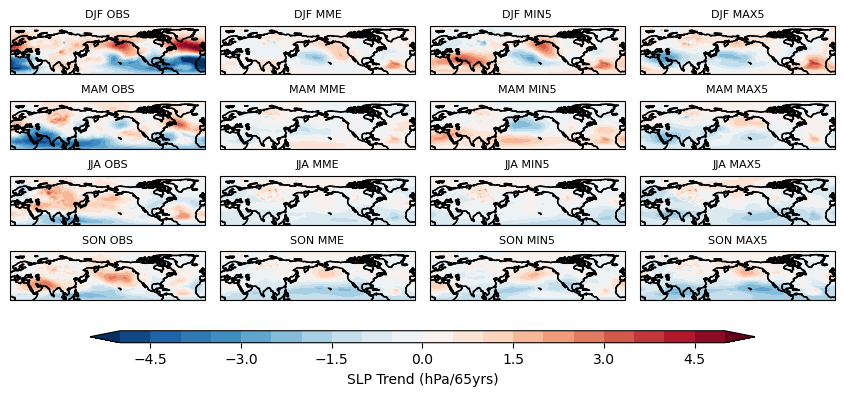

In [90]:
# Update the plot_trend_data function to take the axis as an argument
def plot_trend_data(trend_data, ax, title):
    cmap = mpl.cm.RdBu_r
    bounds = [-5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
    # bounds = [-3.0, -2.75, -2.5, -2.25, -2, -1.75, -1.5,-1.25, -1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3.0]

    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='both')
    ax.coastlines()
    ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree())  # Set the Northern Hemisphere extent
    ax.set_xticks([])
    ax.set_yticks([])
    ax.coastlines()
    ax.add_feature(cfeature.LAND, facecolor='lightgrey')
    ax.add_feature(cfeature.OCEAN, facecolor='white')
    im = ax.imshow(trend_data, extent=[-180, 180, 0, 90], transform=ccrs.PlateCarree(central_longitude=180), cmap=cmap, norm=norm)
    ax.set_title(title,fontname='Times New Roman',fontsize=8)
    # Adding the title as text in the bottom-right corner
    return im

#Creat a function to plot the trend data
fig, axs = plt.subplots(4, 4, figsize=(9.5, 6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# loop over the subplots and plot the data
for i, season in enumerate(['DJF', 'MAM', 'JJA', 'SON']):
    for j, member in enumerate(['OBS', 'MME', 'min5', 'max5']):
        im = plot_trend_data(trend_data[season][member], axs[i, j], f'{season} {member.upper()}')

# add a common colorbar for all subplots
cax = fig.add_axes([0.2, 0.35, 0.7, 0.02])  # [left, bottom, width, height]
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label('SLP Trend (hPa/65yrs)', fontname='Times New Roman',fontsize=10)

# plt.subplots_adjust(hspace=0.1)  # Adjust the spacing between subplots
plt.tight_layout(rect=[0.1, 0.35, 1, 0.95])  # Adjust the layout to accommodate the suptitle and colorbar
plt.savefig('SLP_Trend_Patterns.png', bbox_inches='tight', dpi=300)

plt.show()

In [91]:
# export figure as eps
plt.savefig('SLP_Trend_Patterns.eps', bbox_inches='tight', dpi=300)

<Figure size 640x480 with 0 Axes>